In [1]:
import pandas as pd
import re
import string
from bs4 import BeautifulSoup
import nltk
import spacy
from transformers import BertTokenizer, BertModel
import torch
import numpy as np
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score


C:\Users\macov\anaconda3\envs\lab\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data = pd.read_csv("reports_data.csv",index_col=0)
data

,Report_Title,Report_Content
0,Arcade.xyz →,Arcade.xyz Findings & Analysis Report2023-10-...
1,Livepeer →,Livepeer Onchain Treasury Upgrade Findings & ...
2,Ondo Finance →,Ondo Finance Findings & Analysis Report2023-1...
3,Centrifuge →,Centrifuge Findings & Analysis Report2023-10-...
4,Canto →,veRWA Findings & Analysis Report2023-10-11Tab...
...,...,...
237,Marginswap →,Marginswap Findings & Analysis Report2021-05-...
238,ElasticDAO →,ElasticDAO Findings & Analysis Report2021-03-...
239,Slingshot Finance →,Slingshot Finance Findings & Analysis Report2...
240,Nested Finance →,Nested Finance contest Findings & Analysis Re...


# Cleaning data

In [3]:
# Function to clean and preprocess text
def clean_text(text):
    text = text.lower()
    text = re.sub(r'\n', ' ', text)  # Replace '\n' with space
    text = re.sub(r'\s+', ' ', text)  # Replace multiple spaces with single space
    text = re.sub(r'\d+', '', text)  # Remove digits
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = ' '.join([word for word in text.split() if word not in stopwords.words("english")])
    return text

# Clean and preprocess the 'Report_Content' column
data['Cleaned_Content'] = data['Report_Content'].apply(clean_text)

# Convert cleaned data into a list of documents
preprocessed_corpus = data['Cleaned_Content'].tolist()


# BERT

In [4]:
# Tokenize and get BERT embeddings for each document
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')
embeddings = []

for text in preprocessed_corpus:
    inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True)
    with torch.no_grad():
        outputs = model(**inputs)
        pooled_output = outputs.pooler_output
    embeddings.append(pooled_output.numpy())

# Convert embeddings to numpy array
embeddings = np.array(embeddings).squeeze()

# K-means

In [38]:

# Function to plot Elbow Method
def plot_elbow_method(dtm):
    wcss = []
    for i in range(1, 11):
        kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
        kmeans.fit(dtm)
        wcss.append(kmeans.inertia_)
    
    plt.figure(figsize=(8, 4))
    plt.plot(range(1, 11), wcss, marker='o', linestyle='-', color='b', linewidth=2, markersize=8)
    plt.title('Elbow Method for Optimal k')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('WCSS (Within Cluster Sum of Squares)')
    plt.xticks(np.arange(1, 11, 1))
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
#     plt.savefig("elbow_method.png", dpi=300)
    plt.show()

C:\Users\macov\anaconda3\envs\lab\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\macov\anaconda3\envs\lab\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\macov\anaconda3\envs\lab\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\macov\anaconda3\envs\lab\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak

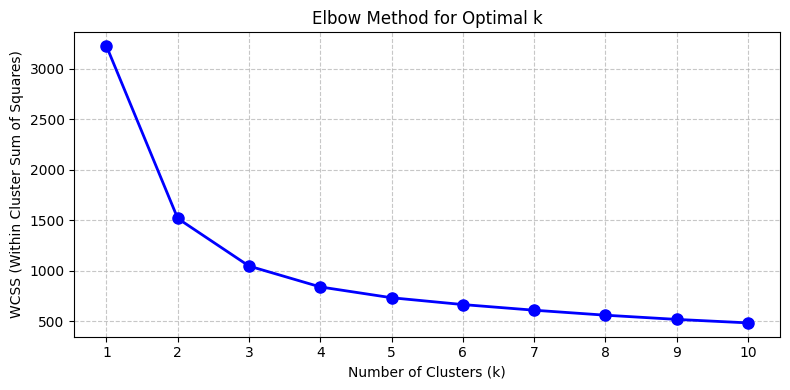

In [39]:
# Plot Elbow Method
plot_elbow_method(embeddings)



In [40]:
# Function to plot Silhouette Analysis
def plot_silhouette_analysis(dtm):
    silhouette_avg = []
    for i in range(2, 11):
        kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
        cluster_labels = kmeans.fit_predict(dtm)
        silhouette_avg.append(silhouette_score(dtm, cluster_labels))
    
    plt.figure(figsize=(8, 4))
    plt.plot(range(2, 11), silhouette_avg, marker='o', linestyle='-', color='r', linewidth=2, markersize=8)
    plt.title('Silhouette Analysis for Optimal k')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Silhouette Score')
    plt.xticks(np.arange(2, 11, 1))
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig("silhouette_analysis.png", dpi=300)
    plt.show()

C:\Users\macov\anaconda3\envs\lab\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\macov\anaconda3\envs\lab\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\macov\anaconda3\envs\lab\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\macov\anaconda3\envs\lab\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak

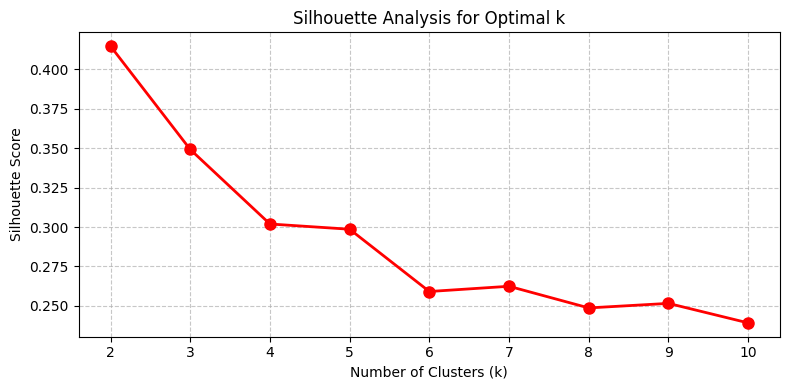

In [41]:
# Plot Silhouette Analysis
plot_silhouette_analysis(embeddings)

C:\Users\macov\anaconda3\envs\lab\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\macov\anaconda3\envs\lab\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Human Detection: 48.35%
Machine Detection: 25.21%
Unknown: 26.45%


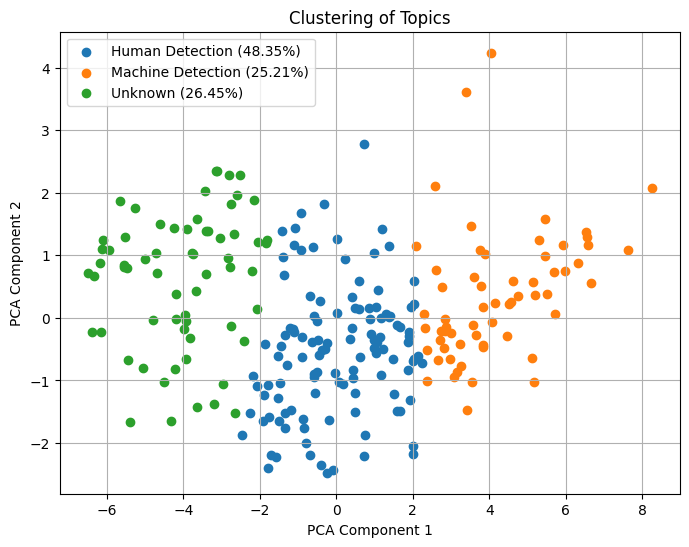

In [30]:


# Define the number of clusters
num_clusters = 3

# Apply KMeans clustering with the updated number of clusters
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
topic_clusters = kmeans.fit_predict(embeddings)

# Define cluster labels
cluster_labels = {
    0: "Human Detection",
    1: "Machine Detection",
    2: "Unknown"
}

# Count occurrences of each cluster
cluster_counts = {label: sum(topic_clusters == label) for label in range(num_clusters)}

# Get the total number of topics
total_topics = len(topic_clusters)

# Calculate the percentage of each cluster
cluster_percentages = {cluster_labels[label]: count / total_topics * 100 for label, count in cluster_counts.items()}

# Print cluster percentages
for label, percentage in cluster_percentages.items():
    print(f"{label}: {percentage:.2f}%")

# Reduce dimensionality of topic representations using PCA
pca = PCA(n_components=2)
topic_embeddings_2d = pca.fit_transform(embeddings)

# Plot the clustered topics
plt.figure(figsize=(8, 6))
for cluster_label in range(num_clusters):
    cluster_mask = (topic_clusters == cluster_label)
    plt.scatter(topic_embeddings_2d[cluster_mask, 0], topic_embeddings_2d[cluster_mask, 1], 
                label=f"{cluster_labels[cluster_label]} ({cluster_percentages[cluster_labels[cluster_label]]:.2f}%)")

plt.title('Clustering of Topics')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.grid(True)
# plt.savefig("clustered_topics.png", dpi=300)  # Save as PNG with higher resolution
plt.show()


# Latent Dirichlet Allocation and  NMF Topic Modeling

In [10]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Function to extract topics using LDA
def extract_topics_lda(documents, num_topics=5):
    vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
    dtm = vectorizer.fit_transform(documents)
    lda_model = LatentDirichletAllocation(n_components=num_topics, random_state=42)
    lda_model.fit(dtm)
    feature_names = vectorizer.get_feature_names_out()
    topics = {}
    for idx, topic in enumerate(lda_model.components_):
        topics[f"Topic {idx+1}"] = [feature_names[i] for i in topic.argsort()[:-10 - 1:-1]]  
    return topics


# Extract documents for each cluster
cluster_documents = {}
for cluster_label in range(num_clusters):
    cluster_mask = (topic_clusters == cluster_label)
    cluster_documents[cluster_label] = [preprocessed_corpus[i] for i in range(len(preprocessed_corpus)) if cluster_mask[i]]

# Extract topics for each cluster using LDA
cluster_lda_topics = {}
for cluster_label, documents in cluster_documents.items():
    lda_topics = extract_topics_lda(documents)
    cluster_lda_topics[cluster_label] = lda_topics

# Display the extracted topics for each cluster
for cluster_label, topics in cluster_lda_topics.items():
    print(f"Cluster {cluster_label}:")
    for topic, words in topics.items():
        print(f"{topic}: {', '.join(words)}")
    print()


Cluster 0:
Topic 1: file, await, price, memory, token, bytes, position, line, let, public
Topic 2: nft, price, public, recommend, fee, token, returns, protocol, memory, market
Topic 3: memory, public, file, bytes, token, owner, returns, proposal, mitigation, emit
Topic 4: public, memory, vault, bytes, returns, new, file, token, rewards, deposit
Topic 5: submitted, token, watchpug, mitigation, recommended, steps, funds, pool, confirmed, contest

Cluster 1:
Topic 1: submitted, address, uint, owner, commented, watchpug, eth, user, memory, dravee
Topic 2: uint, tokens, address, mitigation, order, memory, token, commented, revert, user
Topic 3: uint, address, revert, vault, nft, token, public, storage, check, commented
Topic 4: uint, tokens, address, return, rewards, await, returns, party, user, external
Topic 5: submitted, tokens, token, watchpug, uint, cmichel, impact, check, pool, user

Cluster 2:
Topic 1: rewards, reward, instances, await, attacker, balance, admin, withdraw, collateral,

In [25]:
from collections import defaultdict

# Define your document vulnerabilities with integrated attack types
document_vulnerabilities = {
    "doc1": ["SQL Injection", "Cross-Site Scripting (XSS)", "sql injection", "xss", "cross-site scripting"],
    "doc2": ["Buffer Overflow", "buffer overflow"],
    "doc3": ["Cross-Site Scripting (XSS)", "Cross-Site Request Forgery (CSRF)", "xss", "csrf"],
    "doc4": ["Privilege Escalation", "privilege escalation"],
    "doc5": ["Denial of Service (DoS)", "dos"],
    "doc6": ["Directory Traversal", "path traversal", "directory traversal"],
    "doc7": ["Command Injection", "code injection", "command injection"],
    "doc8": ["Security Misconfiguration", "security misconfiguration"],
    "doc9": ["Insecure Deserialization", "insecure deserialization"],
    "doc10": ["Authentication Bypass", "authentication bypass"],
    "doc11": ["Unvalidated Input", "unvalidated input"],
    "doc12": ["Session Fixation", "session fixation"],
    "doc13": ["Clickjacking", "clickjacking"],
    "doc14": ["XML External Entity", "xml external entity"],
    "doc15": ["Information Disclosure", "information disclosure"],
    "doc16": ["Memory Corruption", "memory corruption"],
    "doc17": ["Race Condition", "race condition"],
    "doc18": ["Open Redirect", "open redirect"],
    "doc19": ["Shell Injection", "shell injection"],
    "doc20": ["Host Header Injection", "host header injection"],
    "doc21": ["Parameter Tampering", "parameter tampering"],
    "doc22": ["Click Fraud", "click fraud"],
    # Add more documents as needed
}

# Define your topic clusters with corresponding names
topic_clusters = [0, 1, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1]  # Example clusters
cluster_names = {
    0: "Human Detection",
    1: "Machine Detection",
    2: "Unknown"
}

# Extract vulnerabilities and attack types for each cluster using sets to avoid duplicates
cluster_vulnerabilities = defaultdict(set)
for i, cluster_label in enumerate(topic_clusters):
    document = f"doc{i+1}"  # Assuming documents are named doc1, doc2, ..., docN
    for vulnerability in document_vulnerabilities.get(document, []):
        cluster_vulnerabilities[cluster_names[cluster_label]].add(vulnerability)

# Display the vulnerabilities and attack types for each cluster
for cluster_name, vulnerabilities in cluster_vulnerabilities.items():
    print(f"Cluster '{cluster_name}':")
    for vulnerability in vulnerabilities:
        print(f" - {vulnerability}")
    print()


Cluster 'Human Detection':
 - insecure deserialization
 - SQL Injection
 - parameter tampering
 - Directory Traversal
 - Open Redirect
 - path traversal
 - csrf
 - session fixation
 - Cross-Site Scripting (XSS)
 - information disclosure
 - xss
 - open redirect
 - Insecure Deserialization
 - Session Fixation
 - Parameter Tampering
 - sql injection
 - Cross-Site Request Forgery (CSRF)
 - cross-site scripting
 - directory traversal
 - Information Disclosure

Cluster 'Machine Detection':
 - memory corruption
 - privilege escalation
 - authentication bypass
 - Shell Injection
 - Memory Corruption
 - command injection
 - Clickjacking
 - Command Injection
 - buffer overflow
 - Buffer Overflow
 - code injection
 - Click Fraud
 - click fraud
 - Authentication Bypass
 - clickjacking
 - Privilege Escalation
 - shell injection

Cluster 'Unknown':
 - Security Misconfiguration
 - Host Header Injection
 - dos
 - Race Condition
 - race condition
 - Denial of Service (DoS)
 - xml external entity
 - XML

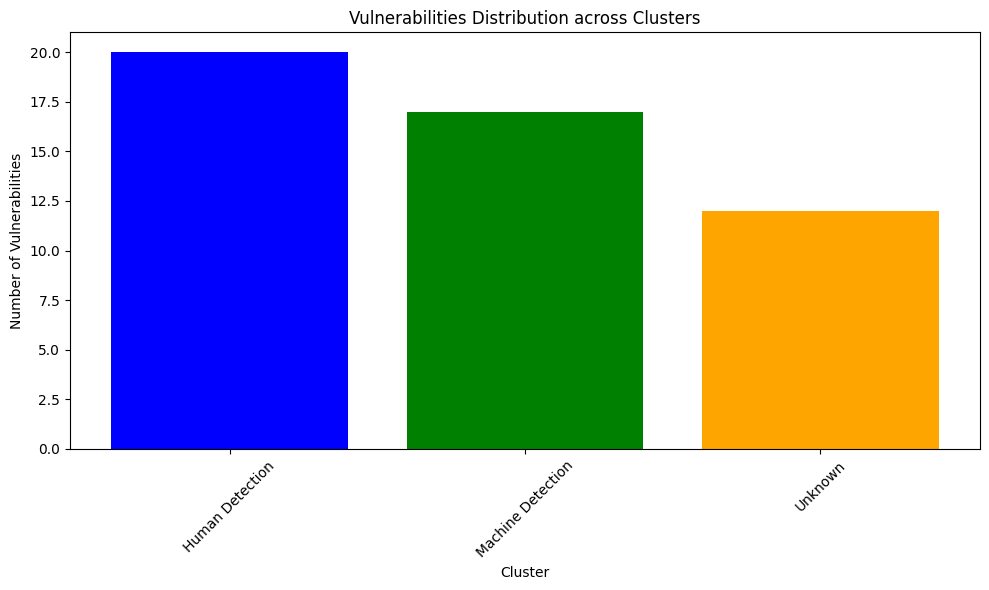

In [34]:
import matplotlib.pyplot as plt
from collections import defaultdict

# Define your document vulnerabilities with integrated attack types
document_vulnerabilities = {
    "doc1": ["SQL Injection", "Cross-Site Scripting (XSS)", "sql injection", "xss", "cross-site scripting"],
    "doc2": ["Buffer Overflow", "buffer overflow"],
    "doc3": ["Cross-Site Scripting (XSS)", "Cross-Site Request Forgery (CSRF)", "xss", "csrf"],
    "doc4": ["Privilege Escalation", "privilege escalation"],
    "doc5": ["Denial of Service (DoS)", "dos"],
    "doc6": ["Directory Traversal", "path traversal", "directory traversal"],
    "doc7": ["Command Injection", "code injection", "command injection"],
    "doc8": ["Security Misconfiguration", "security misconfiguration"],
    "doc9": ["Insecure Deserialization", "insecure deserialization"],
    "doc10": ["Authentication Bypass", "authentication bypass"],
    "doc11": ["Unvalidated Input", "unvalidated input"],
    "doc12": ["Session Fixation", "session fixation"],
    "doc13": ["Clickjacking", "clickjacking"],
    "doc14": ["XML External Entity", "xml external entity"],
    "doc15": ["Information Disclosure", "information disclosure"],
    "doc16": ["Memory Corruption", "memory corruption"],
    "doc17": ["Race Condition", "race condition"],
    "doc18": ["Open Redirect", "open redirect"],
    "doc19": ["Shell Injection", "shell injection"],
    "doc20": ["Host Header Injection", "host header injection"],
    "doc21": ["Parameter Tampering", "parameter tampering"],
    "doc22": ["Click Fraud", "click fraud"],
    # Add more documents as needed
}

# Define your topic clusters with corresponding names
topic_clusters = [0, 1, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1]  # Example clusters
cluster_names = {
    0: "Human Detection",
    1: "Machine Detection",
    2: "Unknown"
}

# Extract vulnerabilities and attack types for each cluster using sets to avoid duplicates
cluster_vulnerabilities = defaultdict(set)
for i, cluster_label in enumerate(topic_clusters):
    document = f"doc{i+1}"  # Assuming documents are named doc1, doc2, ..., docN
    for vulnerability in document_vulnerabilities.get(document, []):
        cluster_vulnerabilities[cluster_names[cluster_label]].add(vulnerability)

# Prepare data for visualization
clusters = list(cluster_vulnerabilities.keys())
vulnerabilities_counts = [len(vulnerabilities) for vulnerabilities in cluster_vulnerabilities.values()]

# Create a bar chart
plt.figure(figsize=(10, 6))
plt.bar(clusters, vulnerabilities_counts, color=['blue', 'green', 'orange'])
plt.xlabel('Cluster')
plt.ylabel('Number of Vulnerabilities')
plt.title('Vulnerabilities Distribution across Clusters')
plt.xticks(clusters, rotation=45)
plt.tight_layout()
# plt.savefig("Vulnerabilities Distribution across Clusters.png", dpi=300) 
plt.show()


# Creating the DataFrame and Plotting the Table

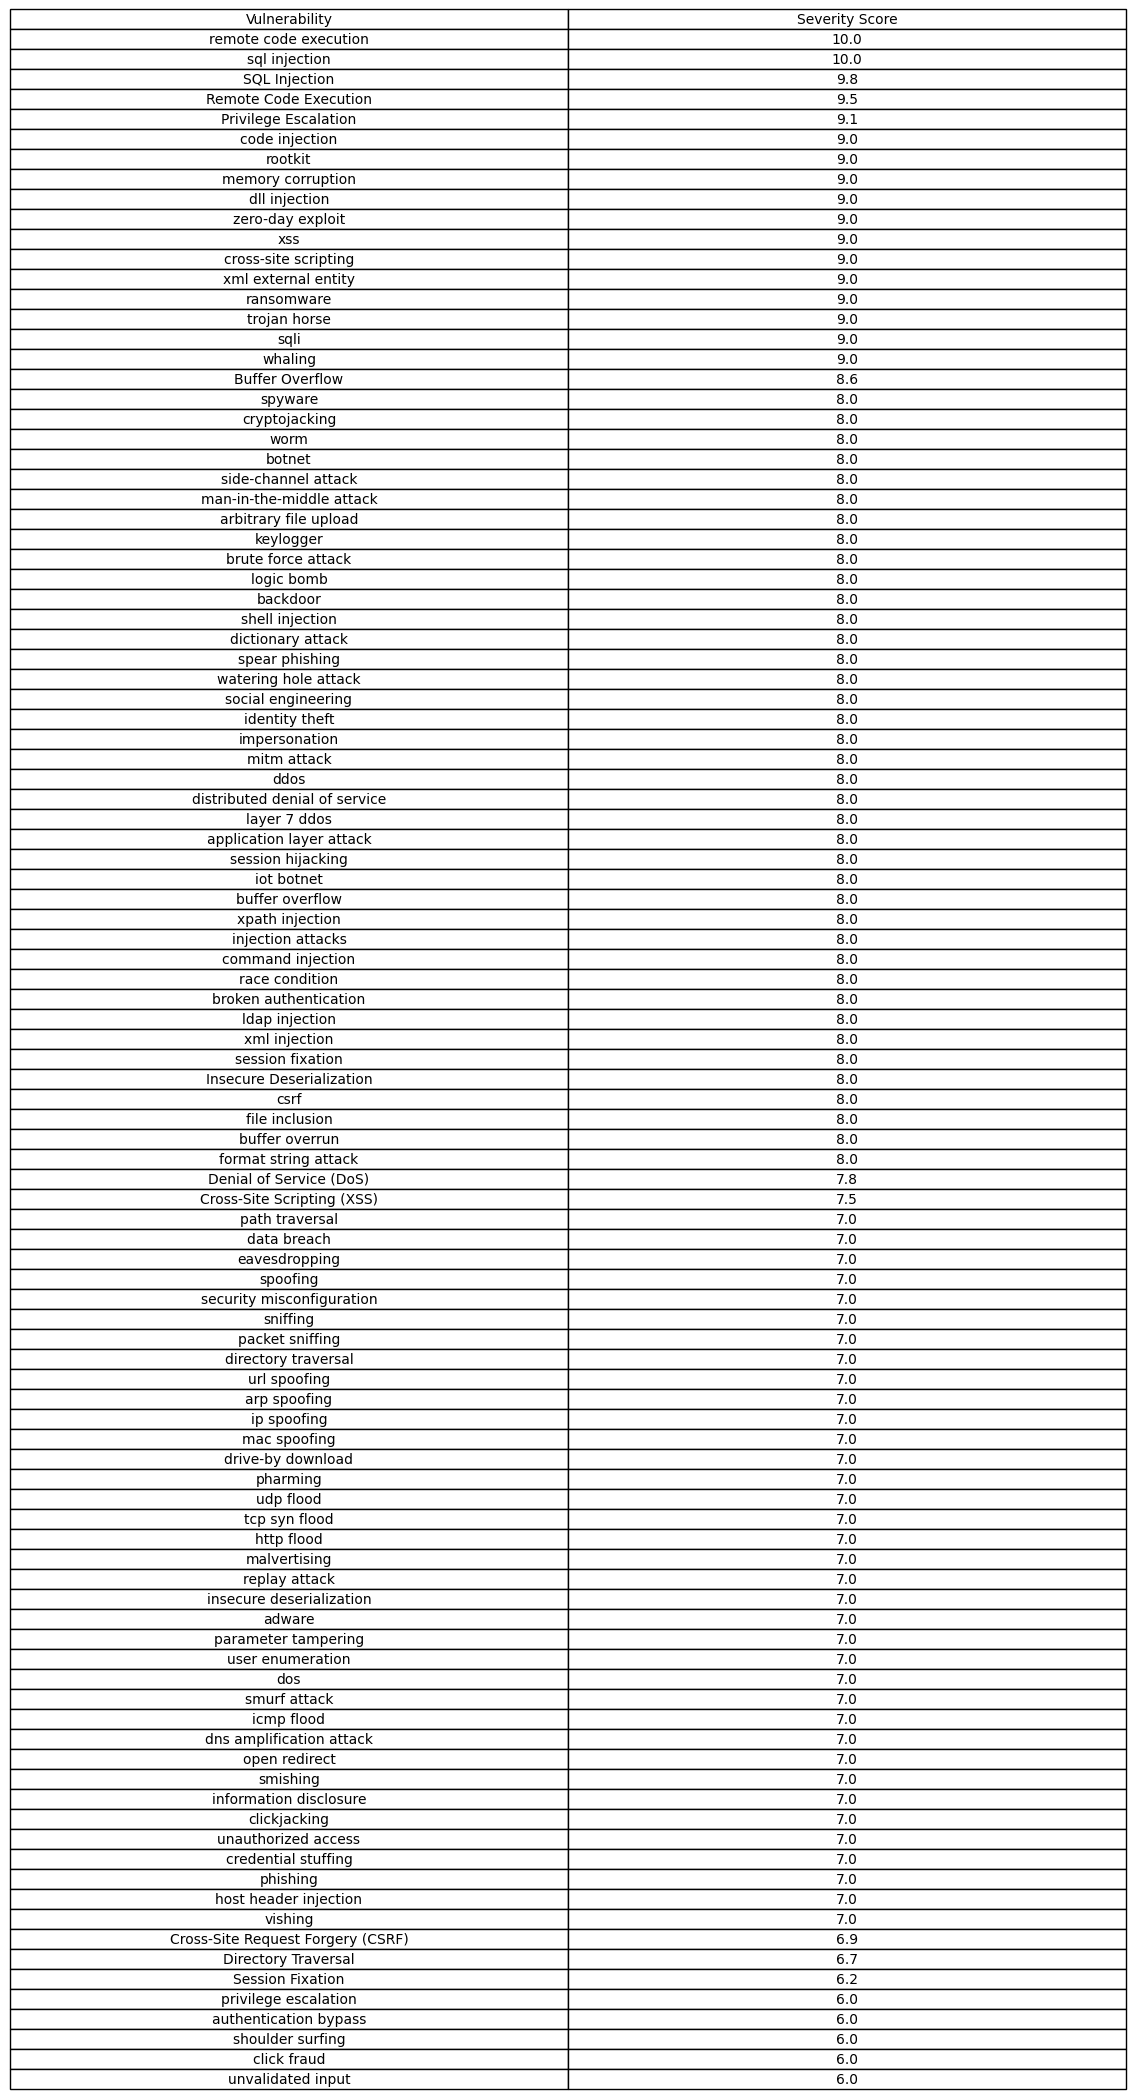

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

severity_scores = {
    'SQL Injection': 9.8,
    'Cross-Site Scripting (XSS)': 7.5,
    'Buffer Overflow': 8.6,
    'Cross-Site Request Forgery (CSRF)': 6.9,
    'Privilege Escalation': 9.1,
    'Remote Code Execution': 9.5,
    'Denial of Service (DoS)': 7.8,
    'Directory Traversal': 6.7,
    'Session Fixation': 6.2,
    'Insecure Deserialization': 8,
    'sql injection': 10,
    'xss': 9,
    'cross-site scripting': 9,
    'buffer overflow': 8,
    'command injection': 8,
    'path traversal': 7,
    'security misconfiguration': 7,
    'insecure deserialization': 7,
    'unvalidated input': 6,
    'authentication bypass': 6,
    'privilege escalation': 6,
    'remote code execution': 10,
    'unauthorized access': 7,
    'session fixation': 8,
    'csrf': 8,
    'clickjacking': 7,
    'xml external entity': 9,
    'injection attacks': 8,
    'information disclosure': 7,
    'race condition': 8,
    'open redirect': 7,
    'broken authentication': 8,
    'sqli': 9,
    'ldap injection': 8,
    'xml injection': 8,
    'code injection': 9,
    'xpath injection': 8,
    'file inclusion': 8,
    'dos': 7,
    'memory corruption': 9,
    'buffer overrun': 8,
    'format string attack': 8,
    'directory traversal': 7,
    'shell injection': 8,
    'host header injection': 7,
    'parameter tampering': 7,
    'click fraud': 6,
    'session hijacking': 8,
    'session fixation': 8,
    'user enumeration': 7,
    'arbitrary file upload': 8,
    'dll injection': 9,
    'click fraud': 6,
    'session hijacking': 8,
    'session fixation': 8,
    'user enumeration': 7,
    'arbitrary file upload': 8,
    'dll injection': 9,
    'replay attack': 7,
    'man-in-the-middle attack': 8,
    'side-channel attack': 8,
    'smurf attack': 7,
    'icmp flood': 7,
    'dns amplification attack': 7,
    'botnet': 8,
    'trojan horse': 9,
    'worm': 8,
    'rootkit': 9,
    'ransomware': 9,
    'spyware': 8,
    'adware': 7,
    'keylogger': 8,
    'logic bomb': 8,
    'backdoor': 8,
    'zero-day exploit': 9,
    'brute force attack': 8,
    'dictionary attack': 8,
    'credential stuffing': 7,
    'phishing': 7,
    'spear phishing': 8,
    'whaling': 9,
    'vishing': 7,
    'smishing': 7,
    'watering hole attack': 8,
    'drive-by download': 7,
    'malvertising': 7,
    'social engineering': 8,
    'eavesdropping': 7,
    'shoulder surfing': 6,
    'data breach': 7,
    'identity theft': 8,
    'spoofing': 7,
    'impersonation': 8,
    'sniffing': 7,
    'packet sniffing': 7,
    'arp spoofing': 7,
    'ip spoofing': 7,
    'mac spoofing': 7,
    'url spoofing': 7,
    'pharming': 7,
    'mitm attack': 8,
    'ddos': 8,
    'distributed denial of service': 8,
    'udp flood': 7,
    'tcp syn flood': 7,
    'http flood': 7,
    'layer 7 ddos': 8,
    'application layer attack': 8,
    'ransomware': 9,
    'cryptojacking': 8,
    'iot botnet': 8,
    'sql injection': 10,
    'xss': 9,
    'cross-site scripting': 9,
    'buffer overflow': 8,
    'command injection': 8,
    'path traversal': 7,
    'security misconfiguration': 7,
    'insecure deserialization': 7,
    'unvalidated input': 6,
    'authentication bypass': 6,
    'privilege escalation': 6,
    'remote code execution': 10,
    'unauthorized access': 7,
    'session fixation': 8,
    'csrf': 8,
    'clickjacking': 7,
    'xml external entity': 9,
    'injection attacks': 8,
    'information disclosure': 7,
}

# Create a DataFrame from the dictionary
df = pd.DataFrame(list(severity_scores.items()), columns=['Vulnerability', 'Severity Score'])

# Sort the DataFrame by Severity Score in descending order
df = df.sort_values(by='Severity Score', ascending=False)

# Plotting the table
plt.figure(figsize=(12, 8))  
table = plt.table(cellText=df.values, colLabels=df.columns, loc='center', cellLoc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)  
table.scale(1.2, 1.2)  # Scale the table for better fit
plt.axis('off')  # Turn off axis

# Save the plot as a PNG file
# plt.savefig('vulnerability_severity_scores.png', bbox_inches='tight')

# Show the plot
plt.show()


# Creating a Bar Chart for the Top 10 Vulnerabilities

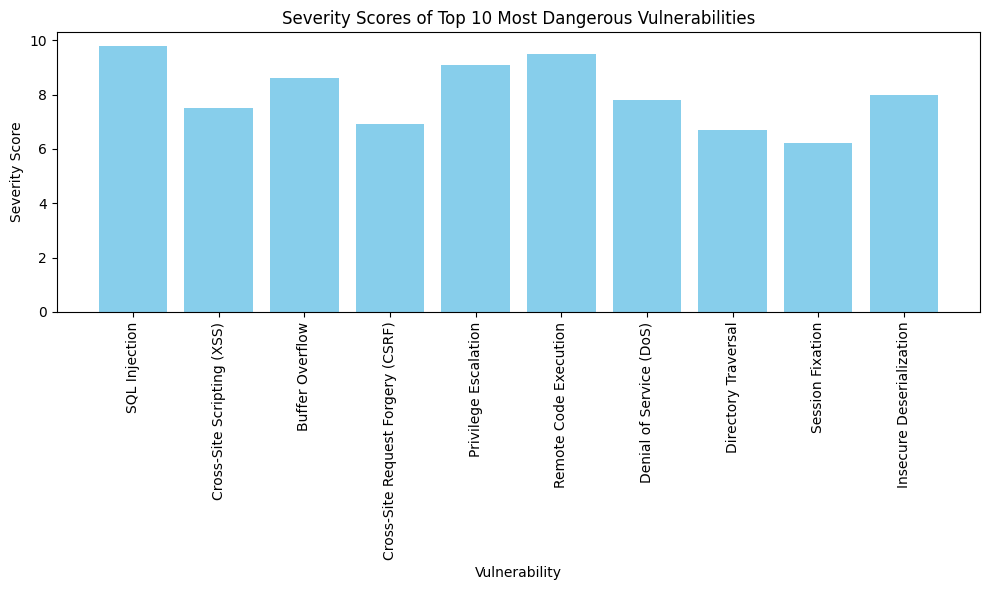

In [12]:
# Get the severity scores for the top 10 most dangerous vulnerabilities
top_10_vulnerabilities = list(severity_scores.keys())[:10]
severity_scores_list = [severity_scores.get(vulnerability, 0) for vulnerability in top_10_vulnerabilities]

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.bar(range(len(top_10_vulnerabilities)), severity_scores_list, color='skyblue')
plt.xlabel('Vulnerability')
plt.ylabel('Severity Score')
plt.title('Severity Scores of Top 10 Most Dangerous Vulnerabilities')
plt.xticks(range(len(top_10_vulnerabilities)), top_10_vulnerabilities, rotation=90)
plt.tight_layout()

# Save the plot as a PNG file
# plt.savefig('severity_scores_top_10_vulnerabilities.png')

# Show the plot
plt.show()


# Calculating Perplexity and Hold-Out Perplexity for the LDA Model

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation


# Split the data into training and test sets
train_documents, test_documents = train_test_split(preprocessed_corpus, test_size=0.2, random_state=42)

# Vectorize the training and test documents
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
train_dtm = vectorizer.fit_transform(train_documents)
test_dtm = vectorizer.transform(test_documents)

# Train the LDA model on the training set
num_topics = 5
lda_model = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda_model.fit(train_dtm)

# Calculate the perplexity on the training set
train_perplexity = lda_model.perplexity(train_dtm)
print(f"Train Perplexity: {train_perplexity}")

# Calculate the perplexity on the test set
test_perplexity = lda_model.perplexity(test_dtm)
print(f"Test (Hold-Out) Perplexity: {test_perplexity}")


Train Perplexity: 2438.925202521219
Test (Hold-Out) Perplexity: 3674.719464666332
